# SVR
So far the best model compared to my strategy of investment is the SVR. \
It has the best ROI even when there are difficult situation to predict. \
Also it's easy to tune and fast to compute, now let's focus on a particular stock and try to maximize the ROI over the last year.

In [14]:
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.svm import SVR
from ForecastSimulator2 import Forecastsimulator, forecast_split
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import date
from dateutil.relativedelta import relativedelta
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import BayesianRidge, ARDRegression

from sklearn.preprocessing import StandardScaler
from pandas_datareader import data as web

plt.rcParams['figure.figsize'] = (18, 10)
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.grid'] = True

In [15]:
data = yf.download(tickers='QBTS', period='7d', interval='1m')
data['Mean'] = (data['High'] + data['Low'])/2
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Mean
Datetime,,,,,,,
2023-06-22 09:30:00-04:00,1.6200,1.6303,1.6000,1.6099,1.6099,150370,1.61515
2023-06-22 09:31:00-04:00,1.6001,1.6040,1.5600,1.5631,1.5631,47213,1.58200
2023-06-22 09:32:00-04:00,1.5602,1.5700,1.4700,1.4700,1.4700,247392,1.52000
2023-06-22 09:33:00-04:00,1.4709,1.5400,1.4709,1.5400,1.5400,276443,1.50545
2023-06-22 09:34:00-04:00,1.5450,1.5485,1.5200,1.5200,1.5200,19574,1.53425
...,...,...,...,...,...,...,...
2023-06-30 15:55:00-04:00,2.1150,2.1200,2.1100,2.1200,2.1200,5438,2.11500
2023-06-30 15:56:00-04:00,2.1150,2.1200,2.1100,2.1150,2.1150,14143,2.11500
2023-06-30 15:57:00-04:00,2.1150,2.1150,2.1100,2.1110,2.1110,3576,2.11250


<Axes: xlabel='Datetime'>

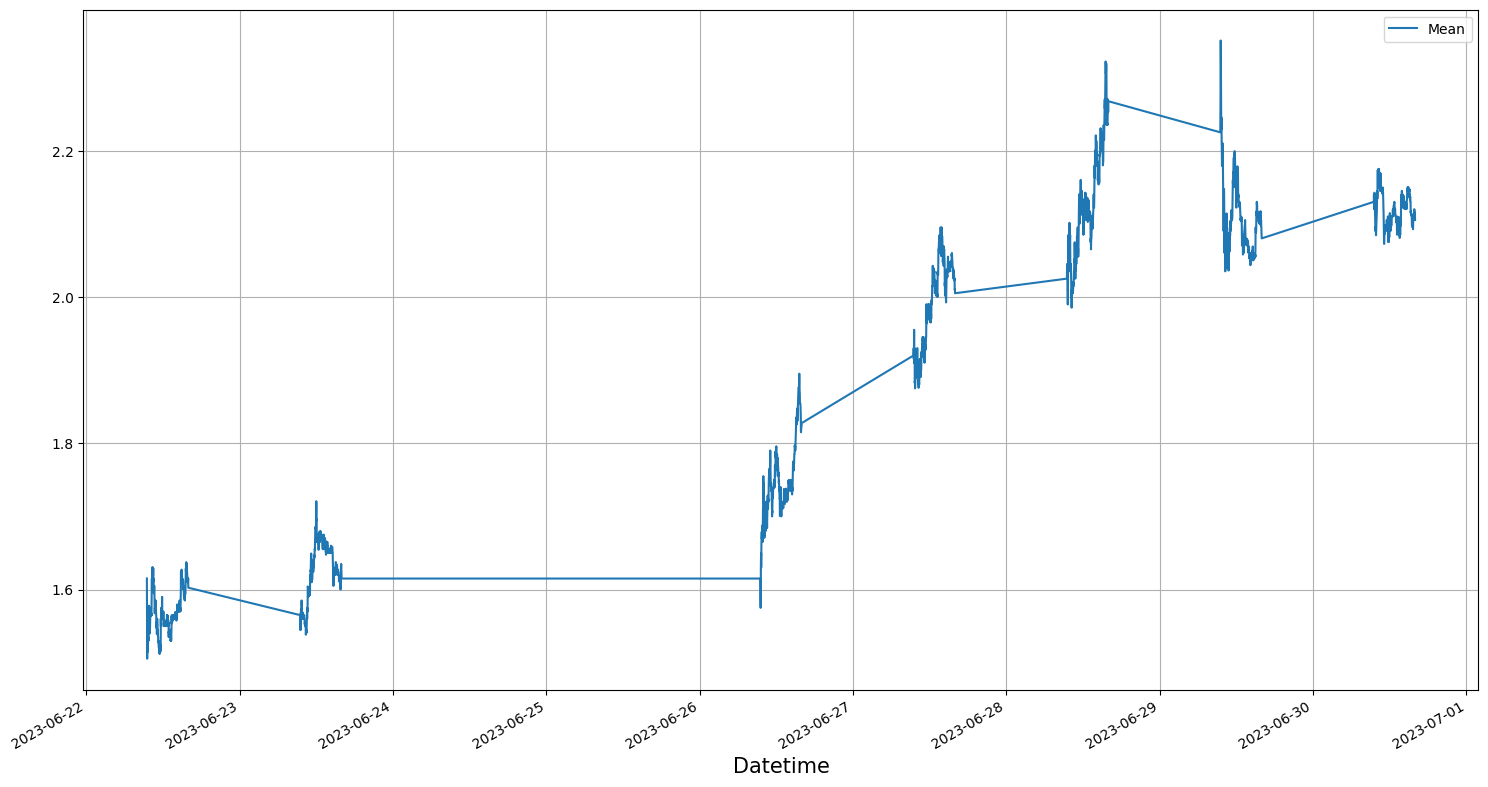

In [16]:
mean = data[['Mean']]
close = data[['Close']]
mean.plot()

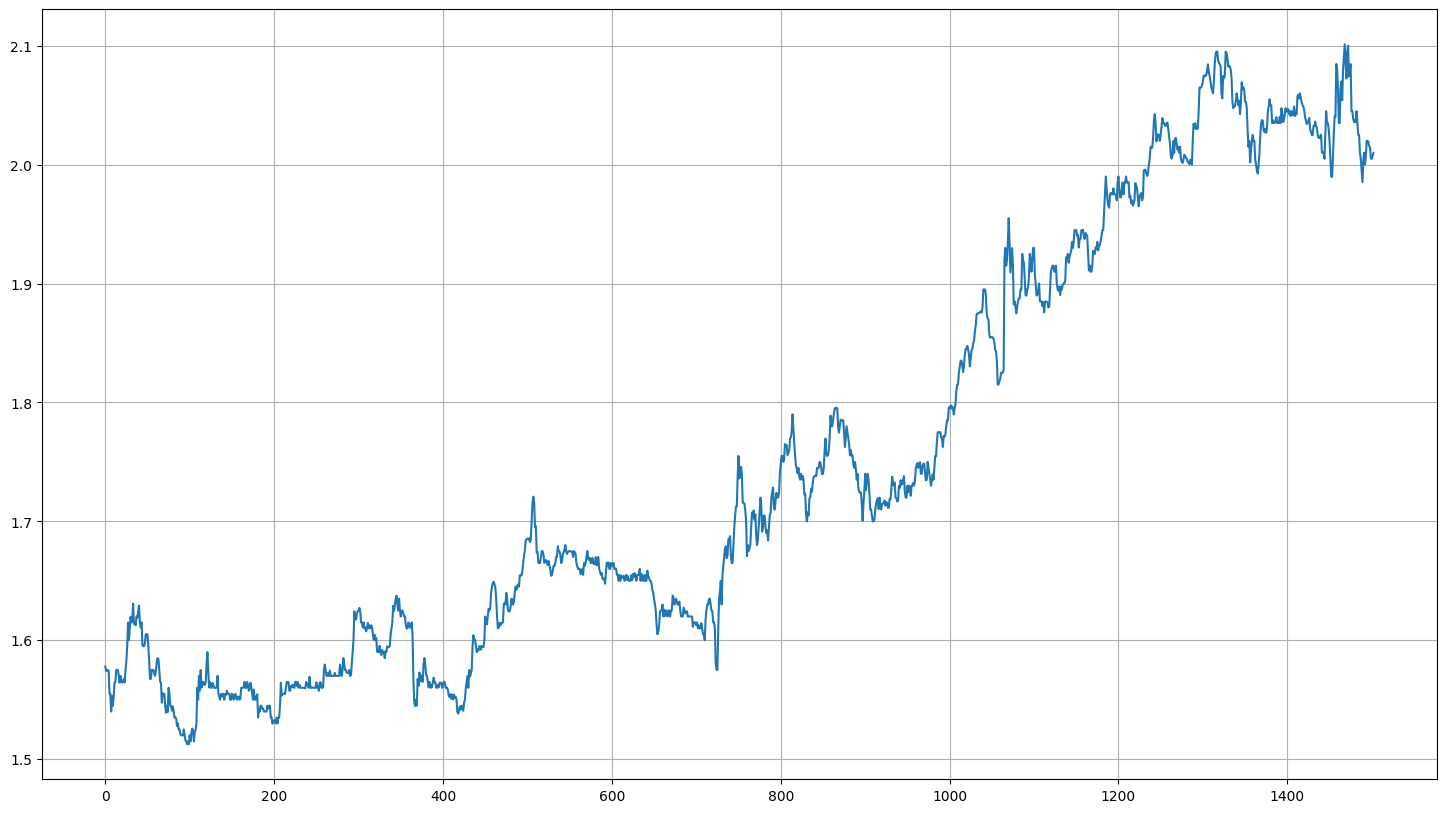

In [17]:
ws=20
dtp=1
X_train, X_test, y_train, y_test, y_true = forecast_split(mean, window_size=ws, dtp=dtp, test_days=1000)
plt.plot(X_train[:,-1])

c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A col

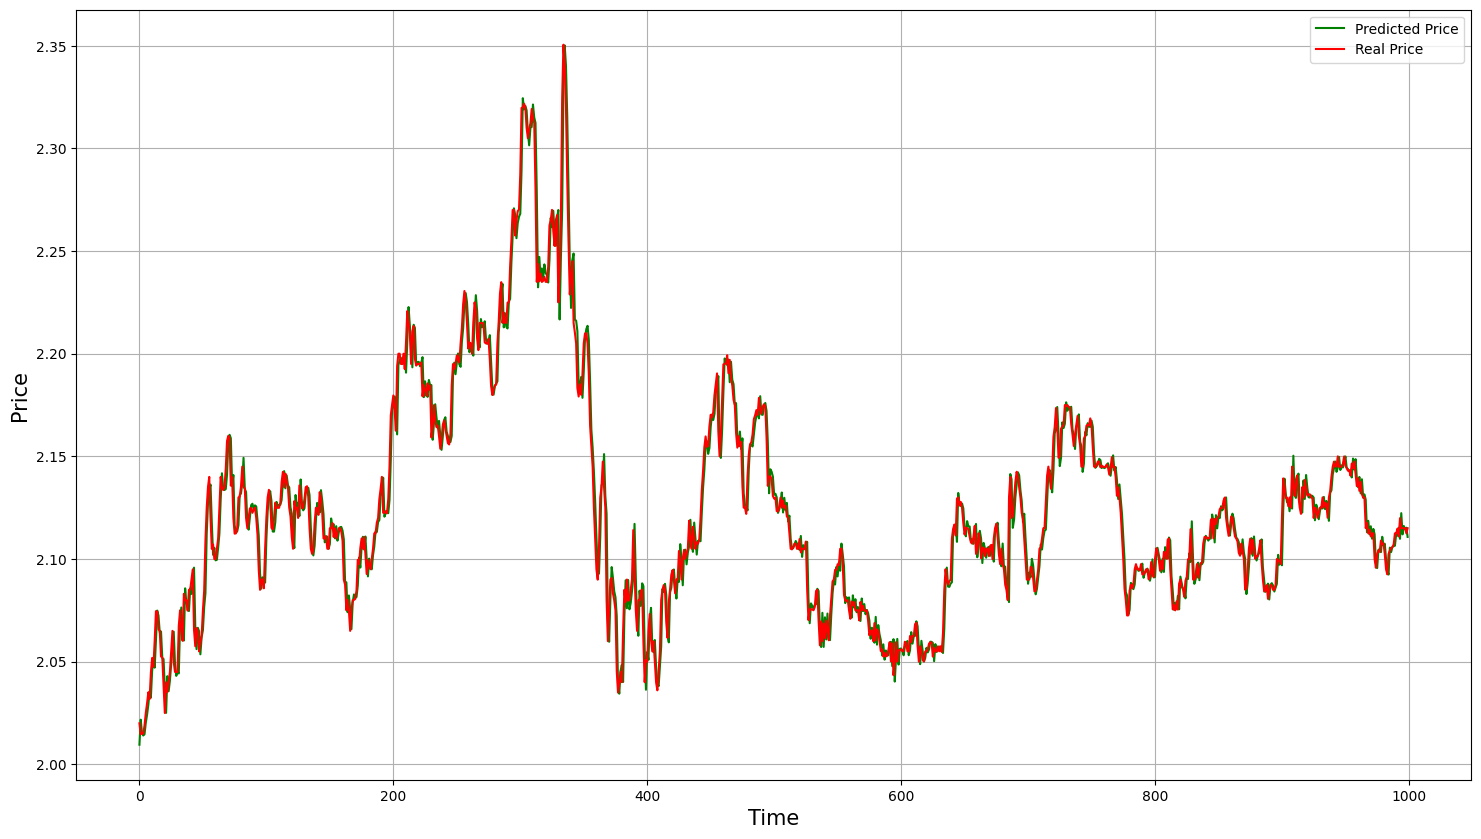

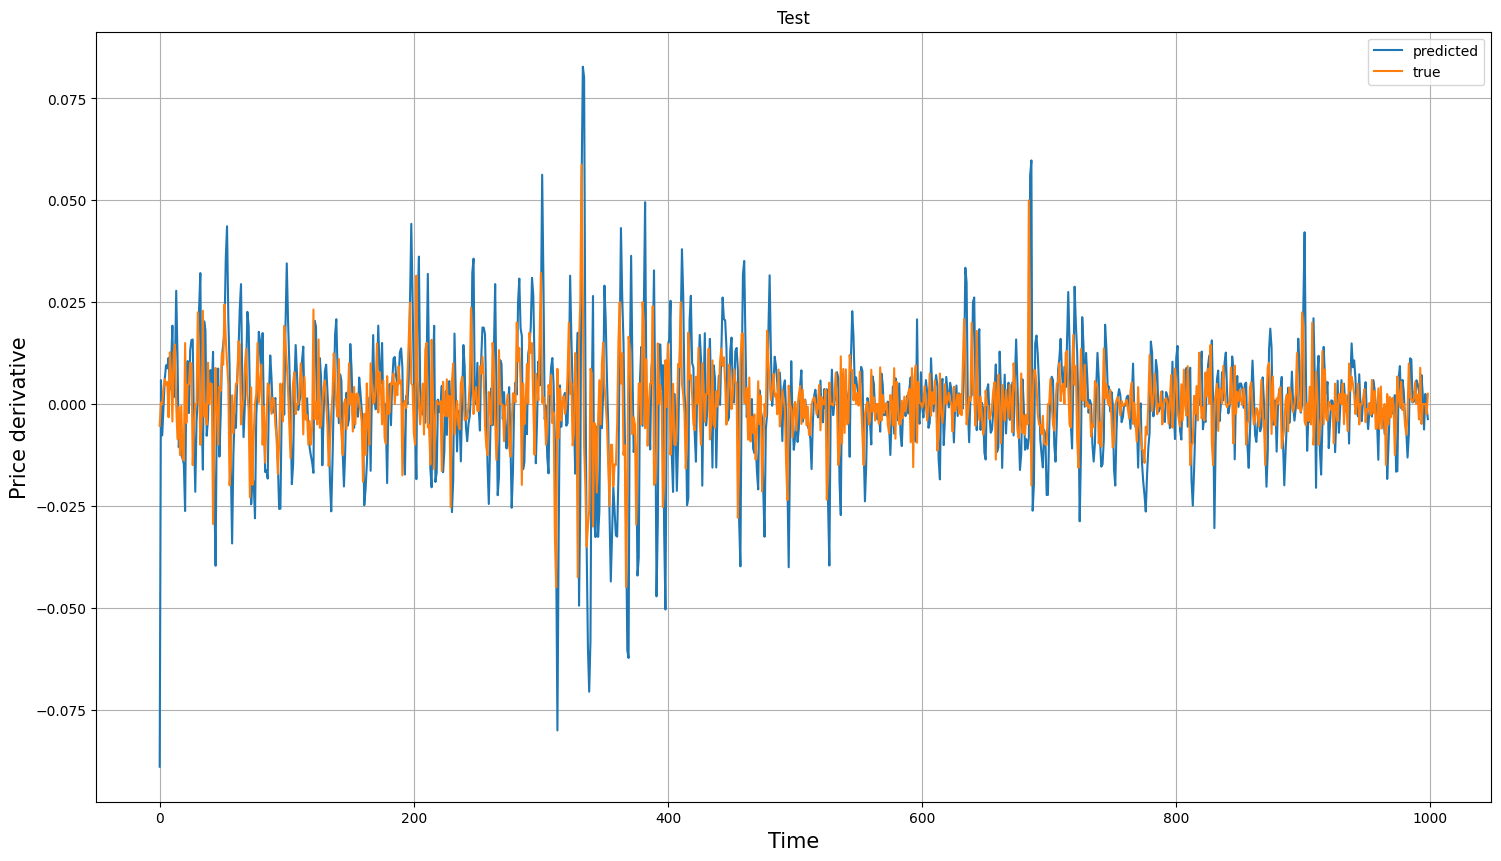

0.548582995951417


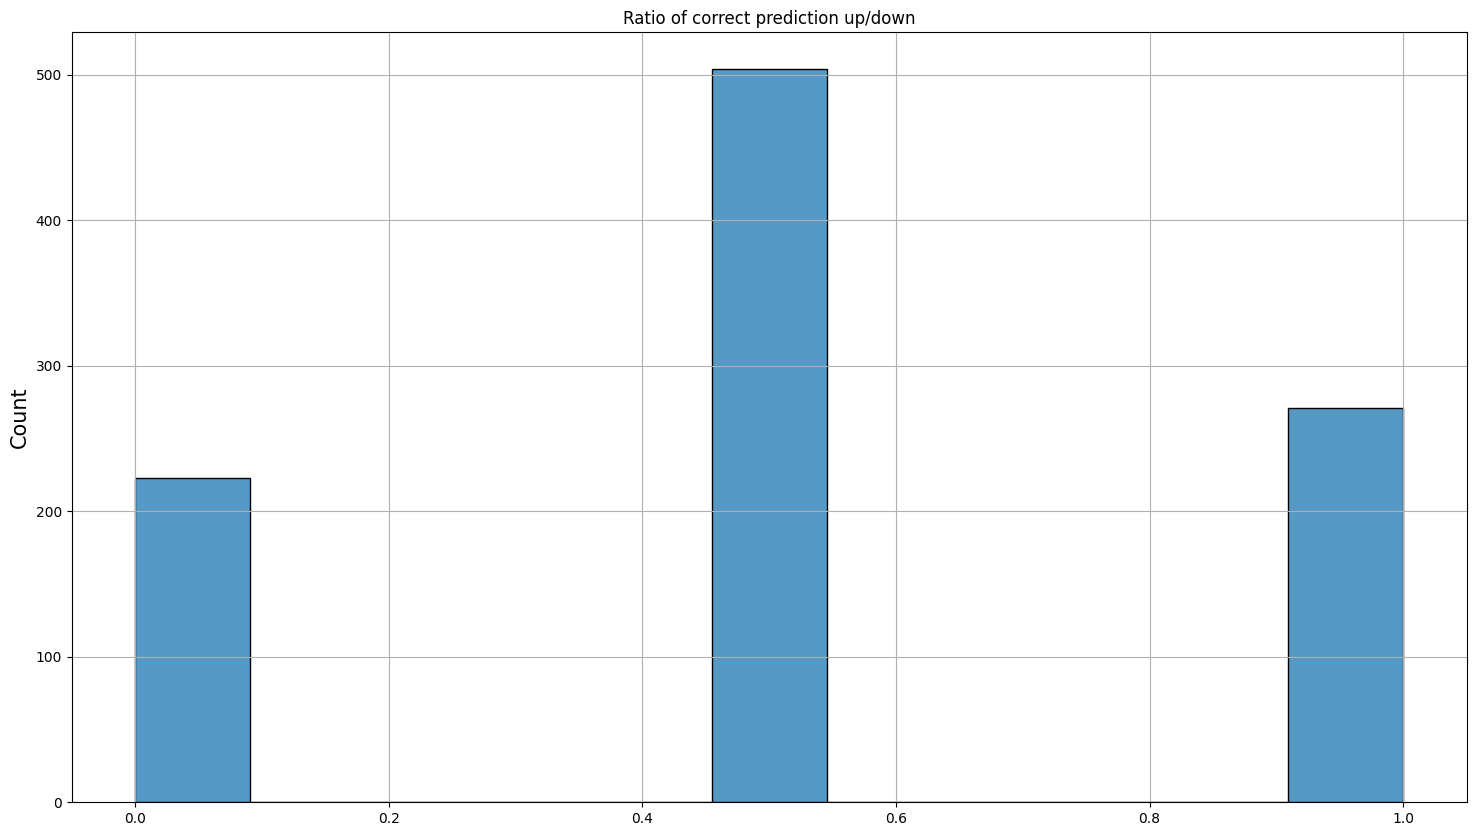

0.019467435918259272 0.3018776973996063


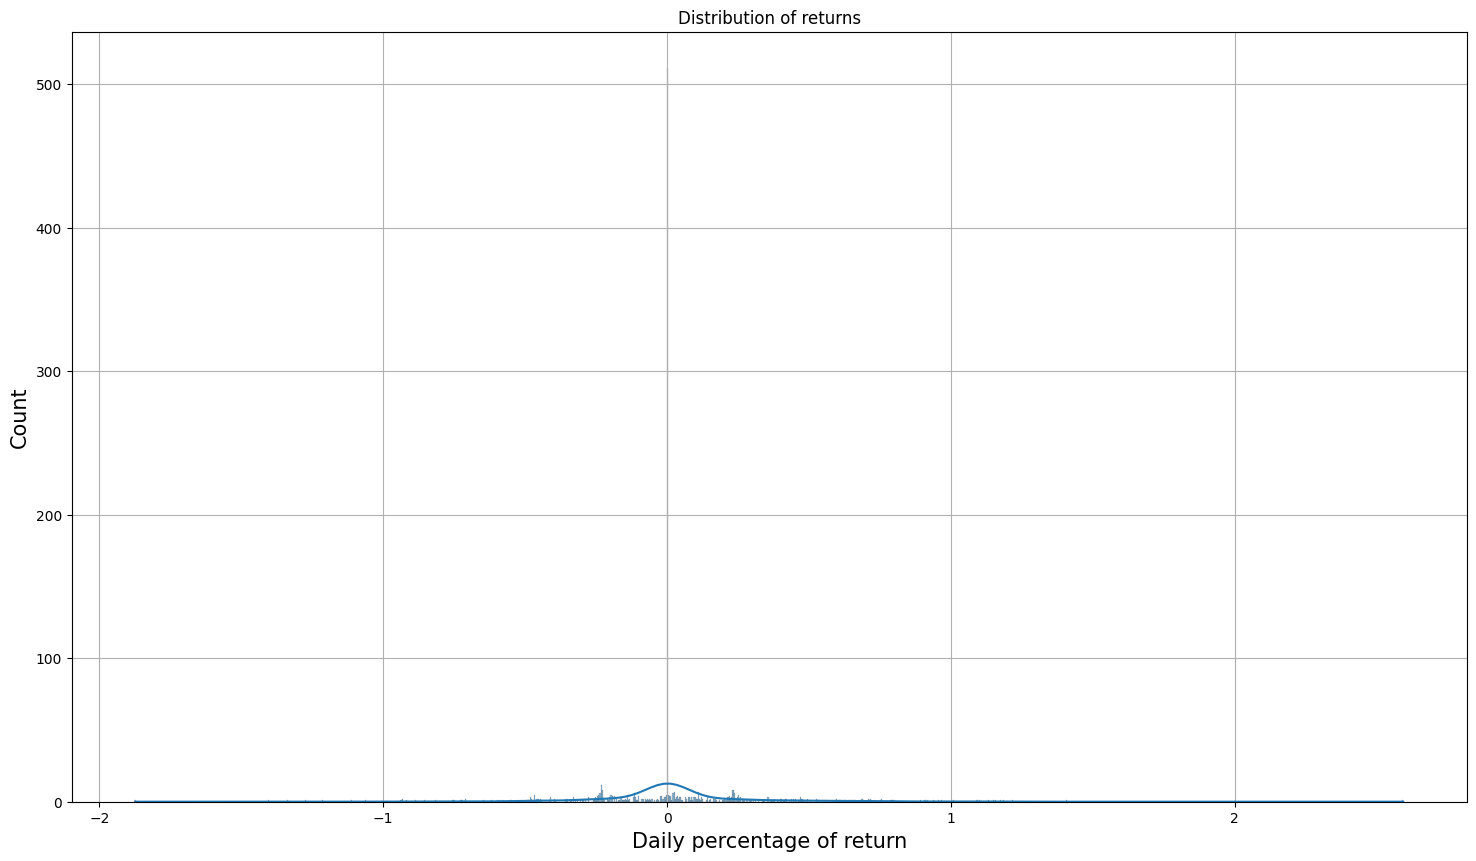

194.28501046422753


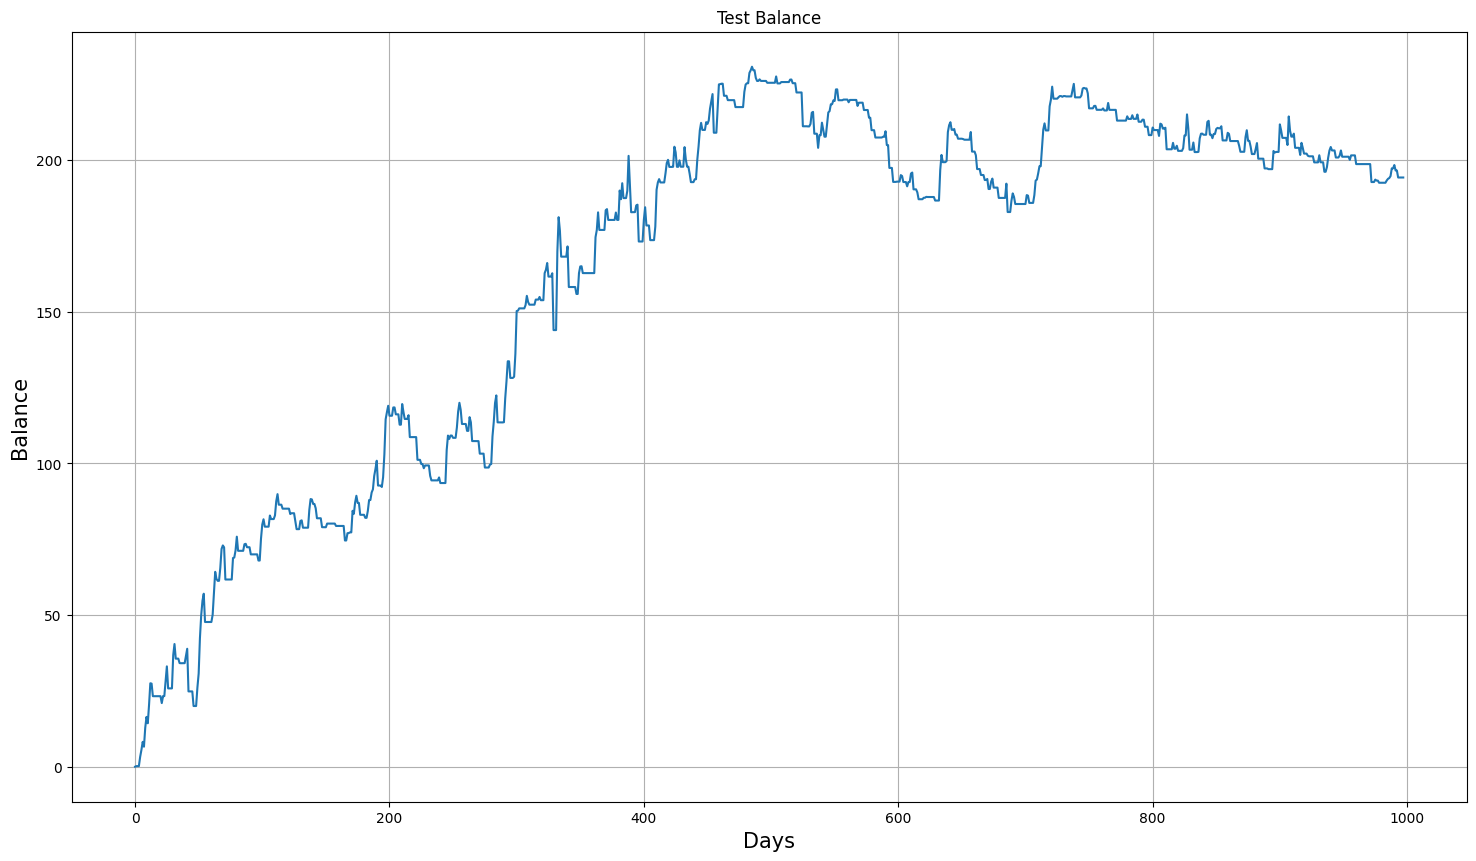

In [18]:
dtp=1
ws=20

X_train, X_test, y_train, y_test, y_true = forecast_split(mean, window_size=ws, dtp=dtp, test_days=1000)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

fs2 = Forecastsimulator(BaggingRegressor(BayesianRidge(lambda_1=0.1, lambda_2=0.1), 50, n_jobs=-1))
pred = fs2.retrain(BaggingRegressor(BayesianRidge(lambda_1=0.1, lambda_2=0.1), 50, n_jobs=-1), X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, retrain_period=60)
prediction = scaler_y.inverse_transform(pred)

fs2.plot_prediction(prediction, y_true)
fs2.simulate(prediction, y_true)

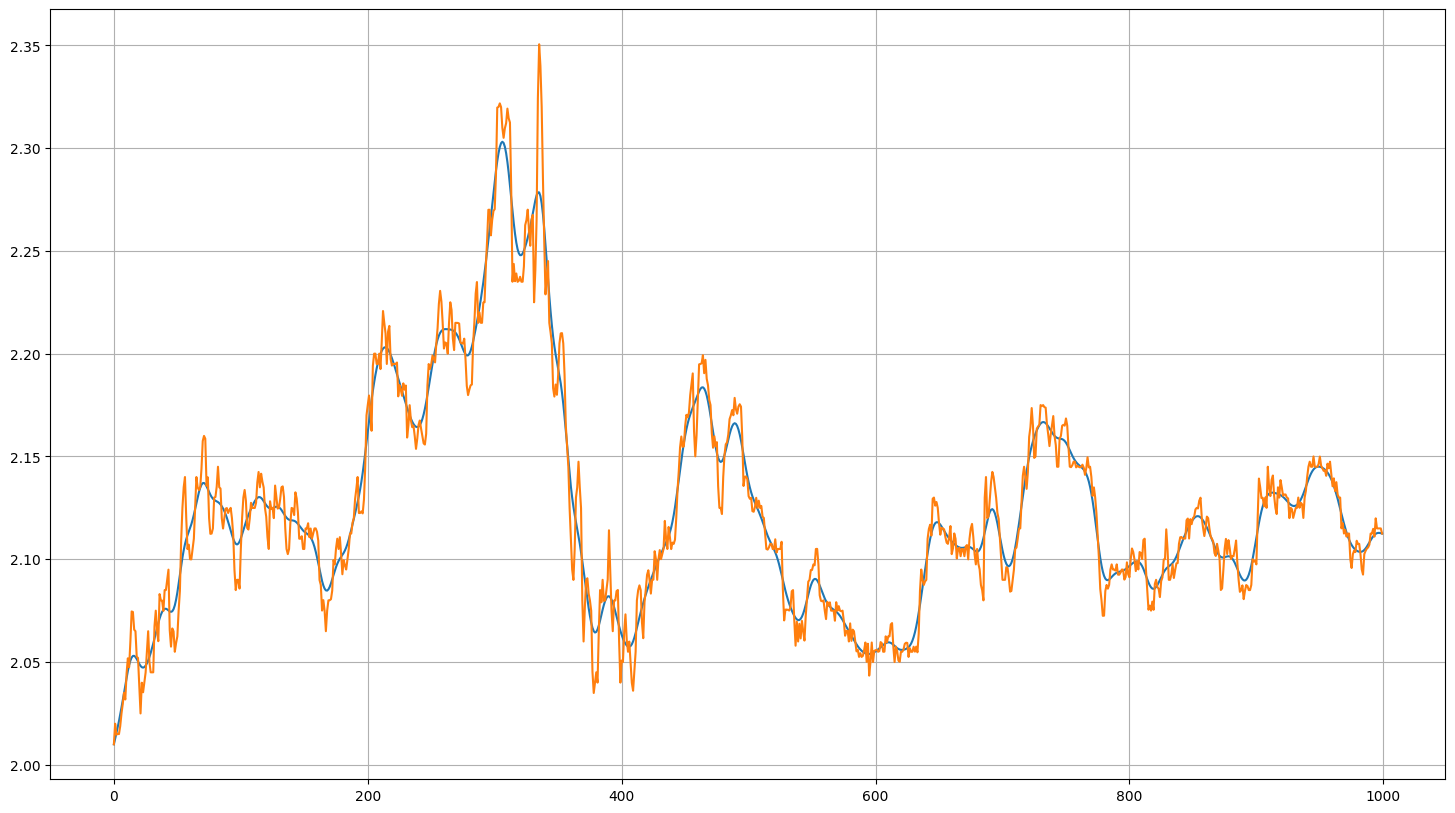

In [70]:
def decadimento(X_train, iterations=200, param=0.1):
    X = X_train.copy()
    
    while iterations > 0:
        for i in range(X.shape[0]-2):
     
            avg = (X[i,:] + X[i+2,:])/2
            X[i+1,:] = (1-param)*X[i+1,:] + param*avg
        iterations -= 1
    return X

X_try = decadimento(X_test)
plt.plot(X_try[:,-1])
plt.plot(X_test[:,-1])

In [71]:
X_test

array([[2.02495  , 2.025    , 2.01     , ..., 2.00745  , 2.00965  ,
        2.01     ],
       [2.025    , 2.01     , 2.00495  , ..., 2.00965  , 2.01     ,
        2.02     ],
       [2.01     , 2.00495  , 1.995    , ..., 2.01     , 2.02     ,
        2.0146499],
       ...,
       [2.1035   , 2.109    , 2.1075   , ..., 2.1149998, 2.1149998,
        2.1149998],
       [2.109    , 2.1075   , 2.1075   , ..., 2.1149998, 2.1149998,
        2.1149998],
       [2.1075   , 2.1075   , 2.1025   , ..., 2.1149998, 2.1149998,
        2.1125   ]], dtype=float32)